In [1]:
### motivation of this notebook: predict rating is a classification problem. 
### By using mean sqared error, and output a single number, we treat it as a regression problem.
### This method for a classification problem is not natural.
### This notebook uses softmax and cross entropy to learn the probability of 5 rating class.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## load data

In [3]:
def load_data():
    age_desc = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
    occupation_desc = {
        0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 
        4: "college/grad student", 5: "customer service", 6: "doctor/health care", 
        7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
        12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
        17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
    rating_data = pd.read_csv(
        "ml-1m/ratings.dat",
        sep="::",
        engine="python",
        encoding="latin-1",
        names=['userid', 'movieid', 'rating', 'timestamp'])
    user_data = pd.read_csv(
        "ml-1m/users.dat", 
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['userid', 'gender', 'age', 'occupation', 'zipcode']
    )
    user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
    user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])
    movie_data = pd.read_csv(
        "ml-1m/movies.dat",
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['movieid', 'title', 'genre']
    )
    dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")
    adj_col = dataset['movieid']
    adj_col_uni = adj_col.sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0:'movieid','index':'adj_movieid'})
    dataset = pd.merge(adj_df,dataset,how="right", on="movieid")
    dataset['adj_userid'] = dataset['userid'] - 1
    return dataset

def train_valid_split(dataset):
    dataset = dataset.sample(frac=1, replace=False)
    n_split = int(len(dataset)*.7)
    trainset = dataset[:n_split]
    validset = dataset[n_split:]
    return trainset, validset

In [4]:
dataset = load_data()
trainset, validset = train_valid_split(dataset)

## create model

In [5]:
### Because we want to have a output of a vector with 5 values. We make movie embedding a tensor of [num_movies, dim, 5]
### This approach increases our parameter by 5 times. 
### In order to not introduce too much new parameter, we do the change on movie, since we have less movies than users in our dataset.
### The meaning of our embedding has changed from learning user features and movie features 
### to user features and movie rating features. 

In [6]:
def create_embeddings(num_users, num_movies, dim):
    user_embeddings = tf.get_variable(
        "theta",
        shape = [num_users, dim, 1],
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    movie_embeddings = tf.get_variable(
        "phi",
        shape = [num_movies, dim, 5],      
        dtype = tf.float32,
        initializer = tf.truncated_normal_initializer(mean=0, stddev=.05)
    )
    return user_embeddings, movie_embeddings

def create_dataset(user_ids, movie_ids, ratings):
    user_id_var = tf.get_variable("userid", initializer=user_ids, trainable=False)
    movie_id_var = tf.get_variable("movieid", initializer=movie_ids, trainable=False)
    ratings_var = tf.get_variable("ratings", initializer=np.asarray(ratings - 1, dtype=np.int32), trainable=False)
    return user_id_var, movie_id_var, ratings_var

def lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids): 
    selected_user_embeddings = tf.gather(user_embeddings, user_ids)
    selected_movie_embeddings = tf.gather(movie_embeddings, movie_ids)
    return selected_user_embeddings, selected_movie_embeddings

def predict_logits(user_embeddings, movie_embeddings, user_ids, movie_ids):
    sel_usr_embs, sel_mov_embs = lookup_embeddings(user_embeddings, movie_embeddings, user_ids, movie_ids)
    selected_predictions = tf.reduce_sum(sel_usr_embs * sel_mov_embs, axis = 1)
    return selected_predictions

def predict_from_logits(logits):
    predictions = tf.nn.softmax(logits)
    return predictions

def predict(selected_user_embeddings, selected_movie_embeddings):
    logits = predict_logits(selected_user_embeddings, selected_movie_embeddings)
    predictions = predict_from_logits(logits)
    return predictions

def cross_entropy_loss(logits, ratings):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=ratings, logits=logits))
    return loss

## hyperparameter

In [7]:
emb_dim = 8
learning_rate = 2500
epochs = 50
lam = 0.02

In [8]:
with tf.Graph().as_default():
    tf.set_random_seed(123)
    with tf.variable_scope("embeddings"):
        usr_embs, mov_embs = create_embeddings(dataset.adj_userid.max()+1, dataset.adj_movieid.max()+1, emb_dim)
    with tf.variable_scope("train_set"):
        train_data = trainset[["adj_userid", "adj_movieid", "rating"]].values.T
        train_usr_ids, train_mov_ids, train_ratings = create_dataset(*train_data)
    with tf.variable_scope("valid_set"):
        valid_data = validset[["adj_userid", "adj_movieid", "rating"]].values.T
        valid_usr_ids, valid_mov_ids, valid_ratings = create_dataset(*valid_data)
    with tf.variable_scope("training"):
        train_logits = predict_logits(usr_embs, mov_embs, train_usr_ids, train_mov_ids)
        train_preds = predict_from_logits(train_logits)
        train_loss = cross_entropy_loss(train_logits, train_ratings)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        train_usr_embs = optimizer.minimize(train_loss, var_list=[usr_embs])
        train_mov_embs = optimizer.minimize(train_loss, var_list=[mov_embs])
    with tf.variable_scope("validation"):
        valid_logits = predict_logits(usr_embs, mov_embs, valid_usr_ids, valid_mov_ids)
        valid_loss = cross_entropy_loss(valid_logits, valid_ratings)
        valid_preds = predict_from_logits(valid_logits)
    with tf.Session() as sess:
        train_loss_hist, valid_loss_hist = [], []
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            sess.run(train_usr_embs)
            current_train_loss = sess.run([train_loss, train_mov_embs])[0]
            current_valid_loss = sess.run(valid_loss)
            train_loss_hist.append(current_train_loss)
            valid_loss_hist.append(current_valid_loss)
            print("%ith epoch: %f (train loss), %f (valid loss)"%(i+1, current_train_loss, current_valid_loss))
        final_user_embeddings, final_movie_embeddings = sess.run([usr_embs, mov_embs])
        final_valid_predictions = sess.run(valid_preds)

1th epoch: 1.609409 (train loss), 1.609460 (valid loss)
2th epoch: 1.609321 (train loss), 1.609460 (valid loss)
3th epoch: 1.609227 (train loss), 1.609452 (valid loss)
4th epoch: 1.609120 (train loss), 1.609432 (valid loss)
5th epoch: 1.608992 (train loss), 1.609375 (valid loss)
6th epoch: 1.608795 (train loss), 1.609243 (valid loss)
7th epoch: 1.608450 (train loss), 1.608918 (valid loss)
8th epoch: 1.607774 (train loss), 1.608118 (valid loss)
9th epoch: 1.606309 (train loss), 1.606162 (valid loss)
10th epoch: 1.602997 (train loss), 1.601476 (valid loss)
11th epoch: 1.595358 (train loss), 1.590655 (valid loss)
12th epoch: 1.578566 (train loss), 1.567971 (valid loss)
13th epoch: 1.546379 (train loss), 1.529217 (valid loss)
14th epoch: 1.499424 (train loss), 1.481590 (valid loss)
15th epoch: 1.451017 (train loss), 1.438807 (valid loss)
16th epoch: 1.411262 (train loss), 1.405913 (valid loss)
17th epoch: 1.381051 (train loss), 1.381666 (valid loss)
18th epoch: 1.358532 (train loss), 1.363

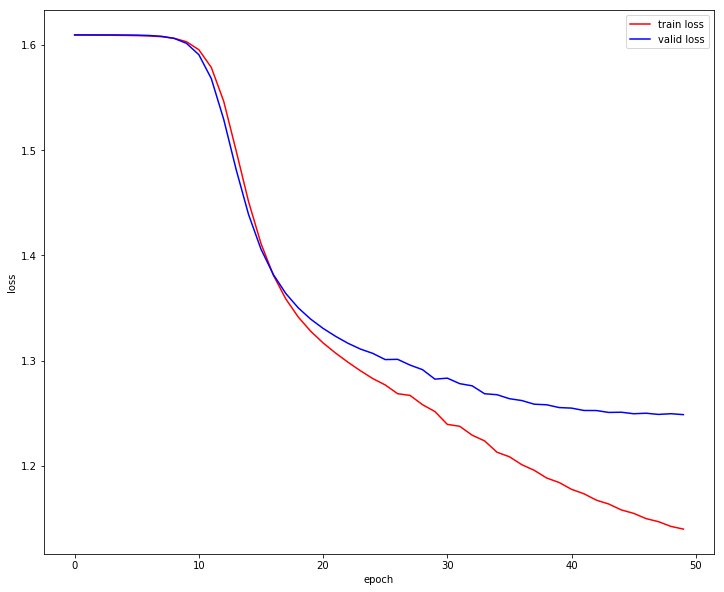

In [10]:
plt.figure(figsize=(12,10))
plt.plot(train_loss_hist, color="red", label="train loss")
plt.plot(valid_loss_hist, color="blue", label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### Measures

In [31]:
results = validset[["gender", "userid","movieid","age_desc","occ_desc", "title", "genre", "rating"]].copy()
results["prediction"] = final_valid_predictions.argmax(axis=1)+1
def compute_recall(prediction_col, target_col):
    recall=[]
    for i in range(5):
        rating_df = results[results[target_col]==i+1]
        num_true_rating = len(rating_df)+0.0
        current_recall = (len(rating_df[rating_df[prediction_col]==i+1]))/num_true_rating
        recall.append(current_recall)
    return recall

def compute_precision(prediction_col, target_col): 
    precision=[]
    for i in range(5):
        pred_df = results[results[prediction_col]==i+1]
        pred_rating = float(len(pred_df))
        current_precision = (len(pred_df[pred_df[target_col]==i+1]))/pred_rating
        precision.append(current_precision)
    return precision    

def compute_mae(prediction_col, target_col):
    return np.mean(np.abs(results[prediction_col]-results[target_col]))

def compute_rmse(prediction_col, target_col):
    return np.sqrt(1/len(results)*np.sum((results[prediction_col]- results[target_col])**2))

In [32]:
for r in range (5):
    print ('Recall for %r star rating is %f' % (r+1, compute_recall('prediction', 'rating')[r]))
for s in range(5):
    print ("Precision for %s star rating is %f" %(s+1, compute_precision('prediction', 'rating')[s]))
    
print ("MAE of this model is %f" %(compute_mae('prediction', 'rating')))
print ("RMSE of this model is %f" %(compute_rmse('prediction', 'rating')))

Recall for 1 star rating is 0.234453
Recall for 2 star rating is 0.156541
Recall for 3 star rating is 0.400064
Recall for 4 star rating is 0.595235
Recall for 5 star rating is 0.463036
Precision for 1 star rating is 0.490064
Precision for 2 star rating is 0.336381
Precision for 3 star rating is 0.408358
Precision for 4 star rating is 0.444788
Precision for 5 star rating is 0.524674
MAE of this model is 0.697697
RMSE of this model is 1.024547


In [67]:
### softmax doesn't capture the order!!! But is order important in our case????